In [1]:
from sqlalchemy import text
from sqlmodel import Session

from ypl.backend.db import get_engine

lim = 5000
raw_query = text(f"""
SELECT t.chat_id, t.turn_id, message_type, content, assistant_model_name, cm.created_at, turn_sequence_number, me.score, e.eval_type FROM chat_messages cm
    JOIN turns t ON cm.turn_id = t.turn_id
    LEFT JOIN message_evals me ON cm.message_id = me.message_id
    LEFT JOIN evals e ON e.eval_id = me.eval_id
WHERE message_type <> 'QUICK_RESPONSE_MESSAGE'
ORDER BY cm.created_at DESC, turn_sequence_number ASC LIMIT {lim};
""")

with Session(get_engine()) as session:
    results = session.execute(raw_query).fetchall()

In [2]:
import pandas as pd

df = pd.DataFrame(results, columns=["chat_id", "turn_id", "message_type", "content", "assistant_model_name", "created_at", "turn_sequence_number", "score", "eval_type"])
df = df.sort_values("created_at")

In [3]:
df.to_csv("simple-router-analysis.csv", index=False)

In [4]:
df

,chat_id,turn_id,message_type,content,assistant_model_name,created_at,turn_sequence_number,score,eval_type
4999,93656db4-65c9-4821-b3ef-4e1b3aa9a536,e4813ab7-0f5f-4ab8-bcde-e22c6a72f895,ASSISTANT_MESSAGE,"I was close, but not quite there. India is a b...",meta-llama/Llama-3.2-3B-Instruct-Turbo,2024-11-04 10:29:35.374000+00:00,2,NaN,None
4998,93656db4-65c9-4821-b3ef-4e1b3aa9a536,e4813ab7-0f5f-4ab8-bcde-e22c6a72f895,ASSISTANT_MESSAGE,"Okay, I see my guess wasn't quite right. Let m...",gemini-1.5-pro-exp-0827,2024-11-04 10:29:38.502000+00:00,3,NaN,None
4997,a95b68bb-222b-471d-9a86-225fc6cebd43,57a16a52-5642-4402-a610-d3af154a88ca,USER_MESSAGE,what are the food options near wework prestige...,None,2024-11-04 10:39:18.547000+00:00,0,NaN,None
4996,a95b68bb-222b-471d-9a86-225fc6cebd43,57a16a52-5642-4402-a610-d3af154a88ca,ASSISTANT_MESSAGE,"Unfortunately, I do not have real-time access ...",gemini-1.5-flash-8b,2024-11-04 10:39:19.408000+00:00,2,NaN,None
4995,a95b68bb-222b-471d-9a86-225fc6cebd43,57a16a52-5642-4402-a610-d3af154a88ca,ASSISTANT_MESSAGE,"I don't have real-time data access, but I can ...",gpt-4-turbo,2024-11-04 10:39:23.775000+00:00,3,NaN,None
...,...,...,...,...,...,...,...,...,...
4,649335f1-803f-42cf-816e-a96548674f52,84da3ccf-9d35-4c97-926f-4c9019a45f9e,ASSISTANT_MESSAGE,PMS can stand for different things depending o...,gpt-4o-2024-05-13,2024-11-23 10:25:46.786000+00:00,3,100.0,SELECTION
3,649335f1-803f-42cf-816e-a96548674f52,84da3ccf-9d35-4c97-926f-4c9019a45f9e,ASSISTANT_MESSAGE,PMS stands for **Premenstrual Syndrome**. It r...,deepseek-coder,2024-11-23 10:25:53.386000+00:00,2,0.0,SELECTION
2,a227854b-809f-4d9f-badc-4bbb06b06c0d,babd40cd-7ba6-42c5-a7e0-5edd31c31c6b,USER_MESSAGE,what is micro frontend architecture,None,2024-11-23 10:51:30.025000+00:00,0,NaN,None
1,a227854b-809f-4d9f-badc-4bbb06b06c0d,babd40cd-7ba6-42c5-a7e0-5edd31c31c6b,ASSISTANT_MESSAGE,Micro frontends are a software development app...,gemini-1.5-flash-8b,2024-11-23 10:51:33.153000+00:00,3,0.0,SELECTION


In [8]:
import requests

from ypl.backend.llm.routing.route_data_type import RoutingPreference, PreferredModel


def replay_to_router(df: pd.DataFrame, api_endpoint: str = "http://localhost:8000/api/v1/select_models"):
    ret_rows = []

    for chat_id, chat_df in df.groupby("chat_id"):
        preference = []

        for turn_id, turn_df in chat_df.groupby("turn_id"):
            try:
                turn1 = turn_df.iloc[1]
                turn2 = turn_df.iloc[2]
            except:
                continue

            body = dict(
                turns=preference
            )
            prompt = turn_df.iloc[0]["content"]

            r = requests.post(
                api_endpoint,
                params={"prompt": prompt, "num_models": 2},
                headers={"X-API-KEY": ""},
                json=body
            )
            if turn1["score"] == 100.0:
                preference.append(PreferredModel(models=[turn1["assistant_model_name"], turn2["assistant_model_name"]], preferred=turn1["assistant_model_name"]).model_dump())
            elif turn2["score"] == 100.0:
                preference.append(PreferredModel(models=[turn1["assistant_model_name"], turn2["assistant_model_name"]], preferred=turn2["assistant_model_name"]).model_dump())

            ret_rows.append(dict(prompt=prompt, models=r.json()))
    
    return pd.DataFrame(ret_rows)


In [7]:
orig_df = replay_to_router(df)

In [10]:
simple_pro_df = replay_to_router(df)

In [22]:
orig_models = []
simple_pro_models = []

for (_, orig_row), (_, simple_pro_row) in zip(orig_df.iterrows(), simple_pro_df.iterrows()):
    assert orig_row["prompt"] == simple_pro_row["prompt"]

    print("Prompt: ", orig_row["prompt"][:100])
    print("Current router models:    ", orig_row["models"])
    print("Simple pro router models: ", simple_pro_row["models"])
    print('-' * 50)

    orig_models.extend(orig_row["models"])
    simple_pro_models.extend(simple_pro_row["models"])

Prompt:  what's the current date
Current router models:     ['gpt-4o-2024-05-13', 'google/gemma-2-9b-it']
Simple pro router models:  ['claude-3-opus-20240229', 'meta-llama/Llama-3.2-3B-Instruct-Turbo']
--------------------------------------------------
Prompt:  how much is 2+2
Current router models:     ['google/gemma-2-27b-it', 'pixtral-12b-2409']
Simple pro router models:  ['meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo', 'gpt-3.5-turbo-0125']
--------------------------------------------------
Prompt:  meaning of // in python
Current router models:     ['google/gemma-2-9b-it', 'google/gemma-2-27b-it']
Simple pro router models:  ['gemini-1.5-pro-exp-0827', 'meta-llama/Llama-3.2-11B-Vision-Instruct-Turbo']
--------------------------------------------------
Prompt:  50 dinner recipes
Current router models:     ['gpt-3.5-turbo-0125', 'qwen/qwen-2.5-72b-instruct']
Simple pro router models:  ['x-ai/grok-beta', 'gpt-4o-2024-08-06']
--------------------------------------------------
Prompt:  

In [12]:
orig_df

,prompt,models
0,what's the current date,"[gpt-4o-2024-05-13, google/gemma-2-9b-it]"
1,how much is 2+2,"[google/gemma-2-27b-it, pixtral-12b-2409]"
2,meaning of // in python,"[google/gemma-2-9b-it, google/gemma-2-27b-it]"
3,50 dinner recipes,"[gpt-3.5-turbo-0125, qwen/qwen-2.5-72b-instruct]"
4,ppp 20$ SF bay equivalent in Bangalore?,"[databricks/dbrx-instruct, gemini-1.5-flash-8b..."
...,...,...
1656,How does the mppt adjust voltage?,"[o1-preview-2024-09-12, nousresearch/hermes-3-..."
1657,What is the efficiency of a good buck boost co...,"[google/gemma-2-9b-it, google/gemma-2-27b-it]"
1658,How does a solar mppt work?,"[x-ai/grok-beta, codestral-2405]"
1659,I’m replacing electrical outlets in an old hou...,"[mistral-medium, gpt-4o-2024-05-13]"


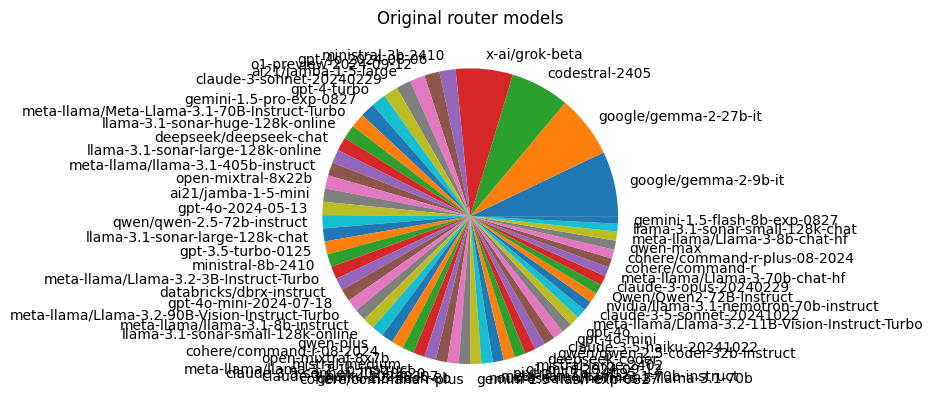

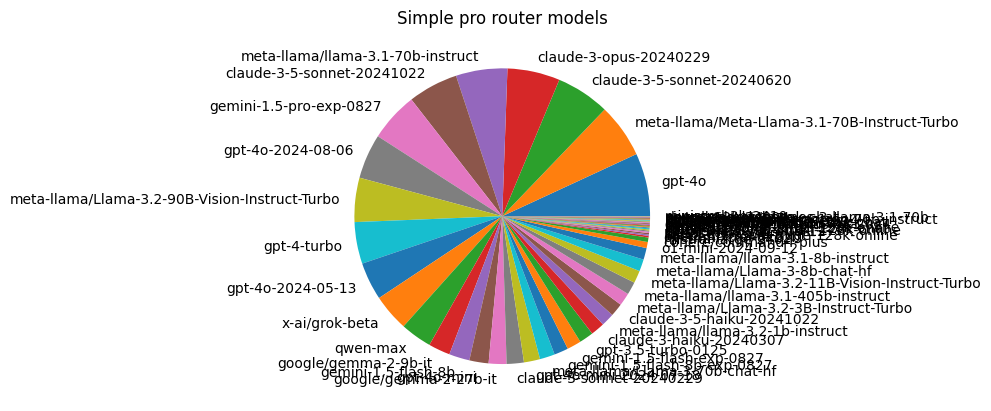

In [25]:
import matplotlib.pyplot as plt

plt.pie(pd.Series(orig_models).value_counts().values, labels=pd.Series(orig_models).value_counts().index)
plt.title("Original router models")
plt.show()

plt.pie(pd.Series(simple_pro_models).value_counts().values, labels=pd.Series(simple_pro_models).value_counts().index)
plt.title("Simple pro router models")
plt.show()

